Preparar o dataset 

Reading the ARFF file

In [1]:
from scipy.io.arff import loadarff
import pandas as pd, numpy as np

data = loadarff('column_diagnosis.arff')
df = pd.DataFrame(data[0])
df['class'] = df['class'].str.decode('utf-8')

Separate input from output data 

In [2]:
features = df.drop('class', axis=1)
target = df['class']

Apply a 10-fold stratified cross-validation with shuffling (random_state=0)

In [3]:
from sklearn.model_selection import StratifiedKFold

acc_folds_gauss = []
acc_folds_knn = []
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

**Exercise 1**
**a)**

Create 𝑘NN with 𝑘 = 5 and naïve Bayes with Gaussian assumption. É necessário realizar o for loop 10 vezes porque existem 10 splits no StatifiedkFold. Train both predictors and compare both lists of accuracies. Each list has 10 accuracies, one per iteration. 

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

gaussNB = GaussianNB()
knn_predictor = KNeighborsClassifier(n_neighbors=5)

# iterate per fold
for train_k, test_k in folds.split(features, target):
    X_train, X_test = features.iloc[train_k], features.iloc[test_k]
    y_train, y_test = target.iloc[train_k], target.iloc[test_k]
    
    ## train and assess
    gaussNB.fit(X_train, y_train)
    y_pred_gauss = gaussNB.predict(X_test)
    acc_folds_gauss.append(round(metrics.accuracy_score(y_test, y_pred_gauss),2))
    
    knn_predictor.fit(X_train, y_train)
    y_pred_knn = knn_predictor.predict(X_test)
    acc_folds_knn.append(round(metrics.accuracy_score(y_test, y_pred_knn),2))

print("Fold accuracies GaussianNB:", acc_folds_gauss)
print("Fold accuracies kNN:", acc_folds_knn)

Fold accuracies GaussianNB: [0.84, 0.87, 0.84, 0.87, 0.77, 0.84, 0.9, 0.81, 0.77, 0.71]
Fold accuracies kNN: [0.94, 0.81, 0.87, 0.94, 0.74, 0.87, 0.84, 0.84, 0.77, 0.77]


Plot the boxplot to see the differences

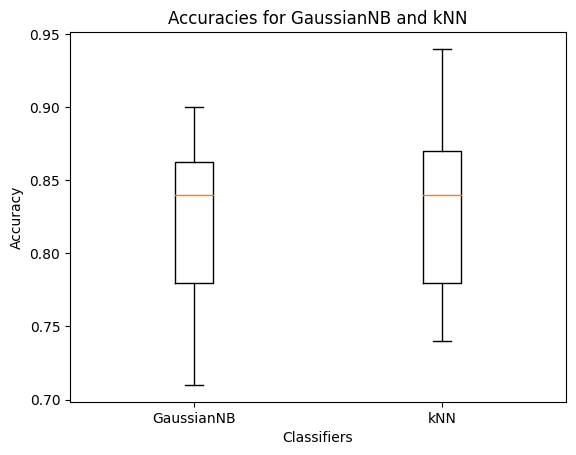

In [5]:
import matplotlib.pyplot as plt

plt.boxplot([acc_folds_gauss, acc_folds_knn], labels=['GaussianNB', 'kNN'])
plt.title('Accuracies for GaussianNB and kNN')
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.show()

**b)**

In [6]:
from scipy import stats

hypothesis = stats.ttest_rel(acc_folds_knn, acc_folds_gauss, alternative='greater')

if hypothesis[1] < 0.05:
    print("The null hypothesis is rejected and kNN is statistically superior to GaussianNB")
    
else:
    print("The null hypothesis is not rejected and there is no statistical superiority between kNN and GaussianNB")

The null hypothesis is not rejected and there is no statistical superiority between kNN and GaussianNB


**Exercise 2**

Initialize the cumulative confusion matrices. In the for loop, create, train and predict test observations for both predictors.
Create confusion matrices per iteration and sum them to the cumulative confusion matrix.

In [7]:
from sklearn.metrics import confusion_matrix

cum_conf_matrix1 = np.zeros((3,3))
cum_conf_matrix5 = np.zeros((3,3))

for train_k, test_k in folds.split(features, target):
    X_train, X_test = features.iloc[train_k], features.iloc[test_k]
    y_train, y_test = target.iloc[train_k], target.iloc[test_k]
    
    ## train and assess
    knn1 = KNeighborsClassifier(n_neighbors=1,weights='uniform',metric='euclidean')
    knn5 = KNeighborsClassifier(n_neighbors=5,weights='uniform',metric='euclidean')

    knn1.fit(X_train, y_train)
    knn5.fit(X_train, y_train)

    # Make predictions
    y_pred1 = knn1.predict(X_test)
    y_pred5 = knn5.predict(X_test)
    
    # Calculate confusion matrices
    conf_matrix1 = confusion_matrix(y_test, y_pred1)
    conf_matrix5 = confusion_matrix(y_test, y_pred5)

    # Calculate cumulative confusion matrices
    cum_conf_matrix1 += conf_matrix1
    cum_conf_matrix5 += conf_matrix5

Calculate the difference between the two confusion matrices and shou that matrix in a Data Frame

In [8]:
conf_matrix_diff = cum_conf_matrix1 - cum_conf_matrix5

confusion1 = pd.DataFrame(conf_matrix_diff, index=knn1.classes_, columns=['Predicted Hernia', 'Predicted Normal', 'Predicted Spondylolisthesis'])
print(confusion1)

                   Predicted Hernia  Predicted Normal  \
Hernia                         -2.0               2.0   
Normal                         -5.0               2.0   
Spondylolisthesis               0.0               1.0   

                   Predicted Spondylolisthesis  
Hernia                                     0.0  
Normal                                     3.0  
Spondylolisthesis                         -1.0  


Create the heatmap with a color bar and numerical values within each cell

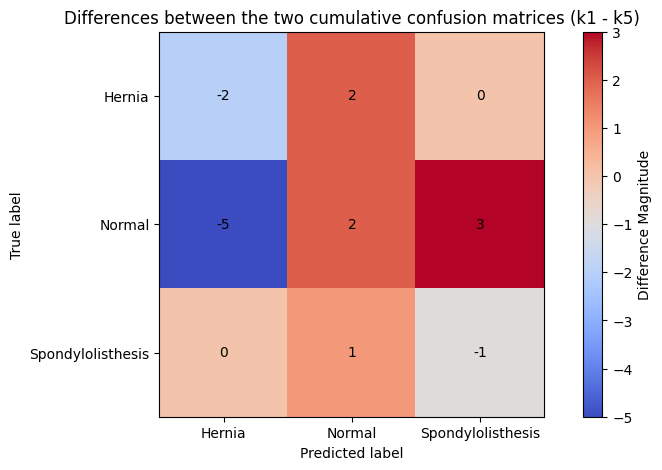

In [9]:
plt.figure(figsize=(10, 5))
heatmap = plt.imshow(conf_matrix_diff,cmap="coolwarm", interpolation='nearest')
plt.title('Differences between the two cumulative confusion matrices (k1 - k5)')
plt.xlabel('Predicted label')
plt.xticks([0, 1, 2], ['Hernia', 'Normal', 'Spondylolisthesis'])
plt.yticks([0, 1, 2], ['Hernia', 'Normal', 'Spondylolisthesis'])
plt.ylabel('True label')


cbar = plt.colorbar(heatmap)
cbar.set_label('Difference Magnitude', rotation=90)

for i in range(conf_matrix_diff.shape[0]):
    for j in range(conf_matrix_diff.shape[1]):
        plt.text(j, i, str(int(conf_matrix_diff[i, j])), ha='center', va='center', color='black')

plt.show()